In [1]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPRegressor

# D
Creating the Franke function with noise.

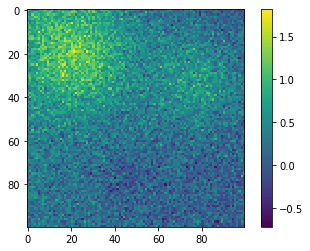

In [3]:
n=100
x = np.linspace(0,1,n)
y = x
x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.25
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)

plt.imshow(frank)
plt.colorbar()
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])
design=fx.DesignDesign(x,y,8)


In [ ]:
epochs=1000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.logspace(-6, -1, 6)
lmbvec = np.logspace(-6, -1, 6)
lmbvec[0]=0
k=5
activation = [lrf.relu, lrf.relu, lrf.relu]
derivative = [lrf.relu_deriv, lrf.relu_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 0,\
                                early_stop_nochange=100, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,50,25], n_neurons = [50,25,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)

test_loss = test_loss/k
test_r2 = test_r2/k

test loss for η = 1e-06 & λ = 0.0 = 0.3059530063518574
test loss for η = 1e-06 & λ = 1e-05 = 0.30595300753828225
test loss for η = 1e-06 & λ = 0.0001 = 0.30595301821608256
test loss for η = 1e-06 & λ = 0.001 = 0.30595312499147004
test loss for η = 1e-06 & λ = 0.01 = 0.30595419248325806
test loss for η = 1e-06 & λ = 0.1 = 0.3059648412110838
test loss for η = 1e-05 & λ = 0.0 = 0.12209856249994888
test loss for η = 1e-05 & λ = 1e-05 = 0.12209845552863915
test loss for η = 1e-05 & λ = 0.0001 = 0.12209749292330456
test loss for η = 1e-05 & λ = 0.001 = 0.1220878805022209
test loss for η = 1e-05 & λ = 0.01 = 0.12199299456480453
test loss for η = 1e-05 & λ = 0.1 = 0.12113384278184611
test loss for η = 0.0001 & λ = 0.0 = 0.0855108070931431
test loss for η = 0.0001 & λ = 1e-05 = 0.08551000369479142
test loss for η = 0.0001 & λ = 0.0001 = 0.08550277669178705
test loss for η = 0.0001 & λ = 0.001 = 0.08543115963518319


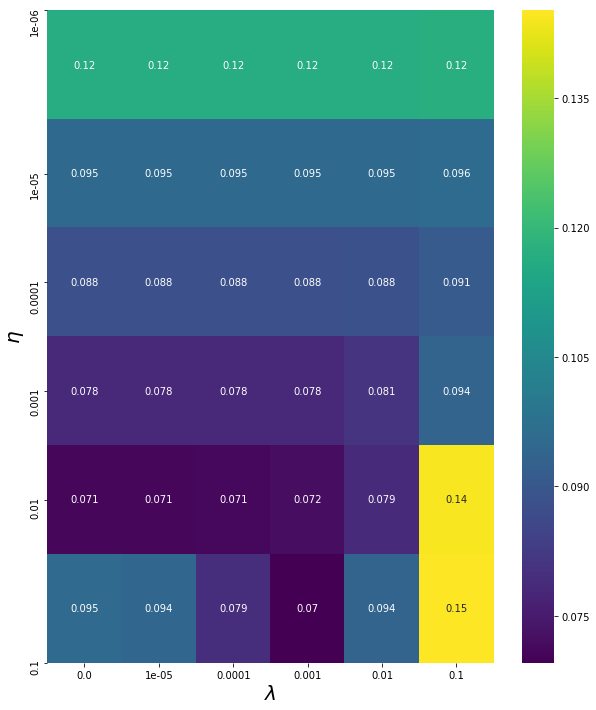

In [4]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_loss, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

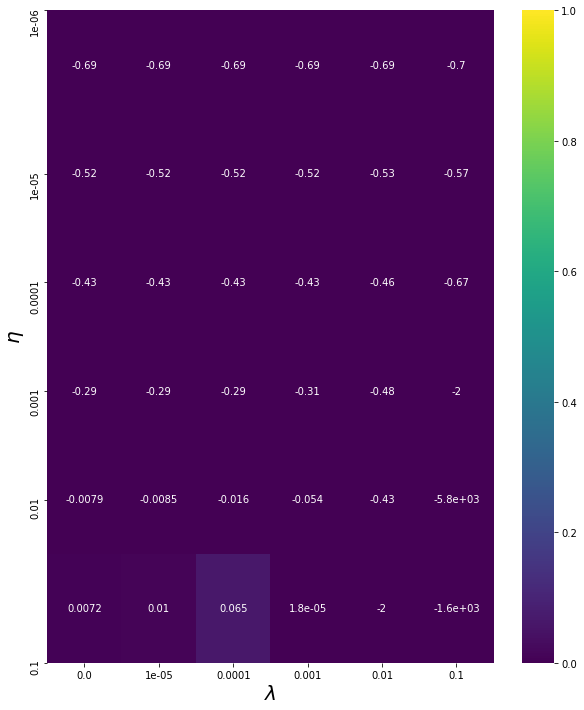

In [5]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_r2, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels, vmin=0, vmax=1)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [6]:
best_eta_index, best_lmb_index = np.where(test_loss == np.min(test_loss))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 
print('eta=',best_eta)
print('lmb=',best_lmb)

eta= [0.1]
lmb= [0.001]


In [35]:
test_loss_best = 0
test_r2_best = 0
k=5
best_eta=0.001
best_lmb=0.0
activation = [lrf.relu, lrf.relu]
derivative = [lrf.relu_deriv, lrf.relu_deriv, lrf.relu_deriv, lrf.relu_deriv, lrf.relu_deriv]

for kf in range(1):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=best_lmb, bias=0, eta=best_eta,early_stop_tol = 0,\
                                early_stop_nochange=200, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,500], n_neurons = [500,1] , n_layers=2)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=True)

            pred = neural_net.feed_out(xtest, activation)
            test_loss_best +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2_best +=  fx.R2Score(pred.ravel(),ytest.T)

test_loss_best /= k
test_r2_best /= k
cost_test, cost_train = neural_net.costs()
print(test_r2_best, 'r2 score')
print(test_loss_best, 'MSE')
            

Epoch 1 loss 0.186253914548303
Epoch 2 loss 0.13788162068793988
Epoch 3 loss 0.11996355811820567
Epoch 4 loss 0.11867762861338042
Epoch 5 loss 0.11247694546403118
Epoch 6 loss 0.10867359129328423
Epoch 7 loss 0.10678566078290737
Epoch 8 loss 0.10543970645328662
Epoch 9 loss 0.10247374167999959
Epoch 10 loss 0.1018883119083373
Epoch 11 loss 0.09755329433108151
Epoch 12 loss 0.10088621819712354
Epoch 13 loss 0.09657460473628875
Epoch 14 loss 0.0963249107493757
Epoch 15 loss 0.09478296930966164
Epoch 16 loss 0.09396425725879762
Epoch 17 loss 0.09275665706367557
Epoch 18 loss 0.09190550759033328
Epoch 19 loss 0.09082063644569098
Epoch 20 loss 0.08991978053296819
Epoch 21 loss 0.09022523953497068
Epoch 22 loss 0.08901132054265577
Epoch 23 loss 0.08927477464226939
Epoch 24 loss 0.08896351058496207
Epoch 25 loss 0.08899572204647192
Epoch 26 loss 0.08747410192716083
Epoch 27 loss 0.08855398180065141
Epoch 28 loss 0.08701638778019319
Epoch 29 loss 0.08661564399748292
Epoch 30 loss 0.08832301107

Epoch 239 loss 0.07528625574609414
Epoch 240 loss 0.07564961546856198
Epoch 241 loss 0.07514906726289813
Epoch 242 loss 0.07488305975244856
Epoch 243 loss 0.07541906930059475
Epoch 244 loss 0.0755606586717204
Epoch 245 loss 0.07488200790292325
Epoch 246 loss 0.07483025500664489
Epoch 247 loss 0.07557204445331793
Epoch 248 loss 0.07568326951459477
Epoch 249 loss 0.07514667933067934
Epoch 250 loss 0.0747283859251016
Epoch 251 loss 0.0746588284435733
Epoch 252 loss 0.0755660162602768
Epoch 253 loss 0.0744292377430206
Epoch 254 loss 0.07464861818164412
Epoch 255 loss 0.0746471612193674
Epoch 256 loss 0.07454992455628043
Epoch 257 loss 0.07499997093750338
Epoch 258 loss 0.07445190316275628
Epoch 259 loss 0.07460968608230445
Epoch 260 loss 0.07488999797804007
Epoch 261 loss 0.07492809719218065
Epoch 262 loss 0.07450003159718845
Epoch 263 loss 0.07499942728922425
Epoch 264 loss 0.07504429822669505
Epoch 265 loss 0.07432286551794223
Epoch 266 loss 0.07473284133283437
Epoch 267 loss 0.074125669

KeyboardInterrupt: 

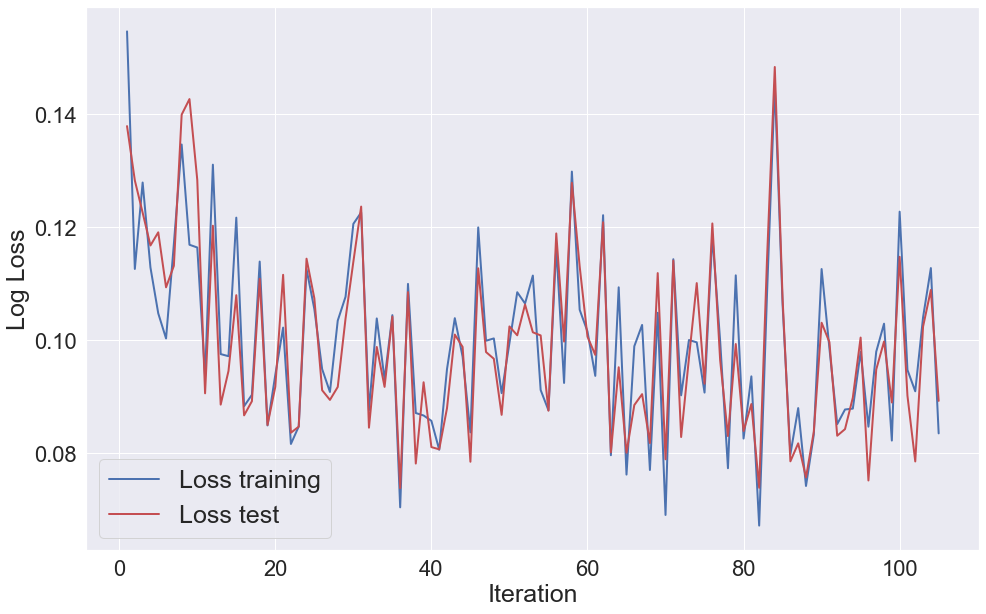

In [31]:
cost_test, cost_train = neural_net.costs()

sns.set(font_scale=2)
plt.figure(figsize=([16,10]))
axis = np.arange(len(cost_train))+1
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('Log Loss',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
plt.show()

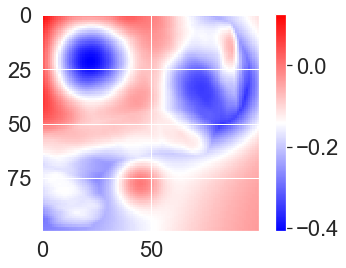

0.7188378536425959


In [32]:
pred = neural_net.feed_out(design, activation)

#plt.subplot(1, 2, 1)
plt.imshow(pred.reshape([n,n])- frank.reshape([n,n]), cmap='bwr')
#plt.subtitle('Predicted')
#plt.subplot(1, 2, 2)
#plt.subtitle('Franke')
#plt.imshow(frank.reshape([n,n]))
plt.colorbar()
plt.show()





print(fx.R2Score(frank.ravel(),pred.ravel()))

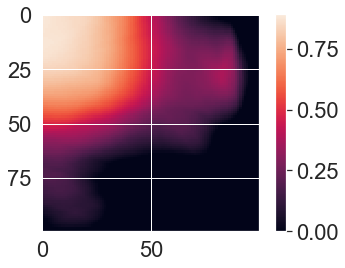

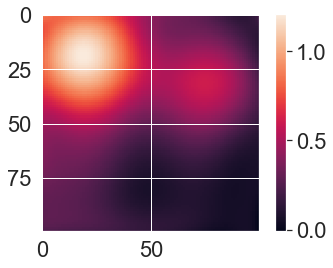

0.57461817396553

In [33]:
pred = neural_net.feed_out(design, activation)



plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

beta, pred = fx.OridinaryLeastSquares(design, frank, design)



plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

fx.R2Score(ytest,xtest@beta)



0.9830693657460222
0.9786826488472629
0.9589358385108006
0.9294037892891827
0.8021417174789522
0.4556894278548118
-3.976163083607709e-05
0.9972687748786746
0.9880647576768603
0.9813564713925473
0.9295816195560719
0.8166500647601069
0.543778138626378
-0.0029691409423500126


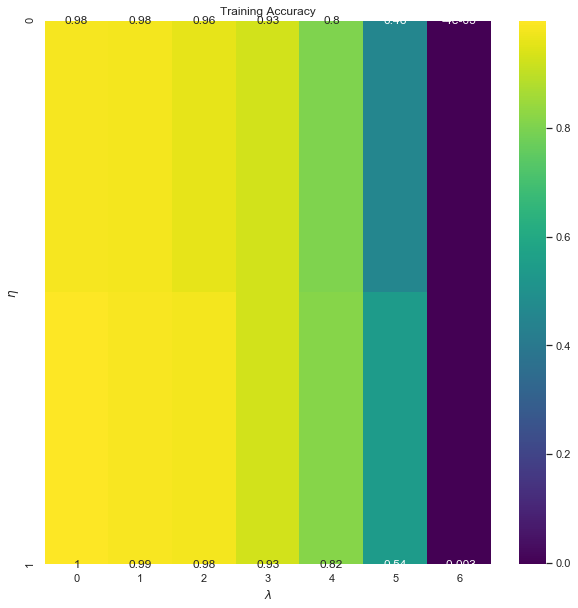

In [54]:
design=fx.DesignDesign(x,y,8)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()

n_hidden_neurons = (50,20)
epochs = 1000
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [55]:
best_eta_index, best_lmb_index = np.where(train_accuracy == np.max(train_accuracy))
best_eta,best_lmb = eta_vals[best_eta_index], lmb_vals[best_lmb_index] 
print(best_eta, 'eta')
print(best_lmb, 'lmb') 


dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbmax, learning_rate_init=etamax, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

NameError: name 'lmb_vals' is not defined

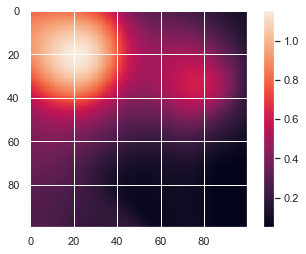

0.9950208839592649


In [49]:
pred = dnn.predict(X_train)


plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

print(fx.R2Score(pred,frank.ravel()))